# AI For Toxicology Screening



## Data Loading


### Adverse effect Data

In [1]:
# Import required libraries For Data Analysis
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files

In [ ]:
# Files to be uploaded locally

files.upload()

### APPROACH 2: Chemical SMILE Notation and Properties data

@Taqi, here I found a way to access pubchem database via a built in python module. We can use this to basically create a pandas dataframe which consists of chemical compounds and their different properties.

However for the sake of proof of concept, the data that I'm using on top of the pubchem db is unique for COVID-19 Drug Discovery purposes

**TL;DR, we are going to carry out feature extraction on this data, transferring the features into a pandas dataframe**

In [ ]:
# Install pubchem library to access the data
# !pip install pubchempy

In [ ]:
import pubchempy as pcp

In [ ]:
# See if we can get one row of this data

prop = pcp.get_properties(['MolecularFormula', 'MolecularWeight', 'CanonicalSMILES', 'IsomericSMILES',
'InChI', 'InChIKey', 'IUPACName'],'CN1N=C(C=C1C(F)(F)F)C1=CC=C(S1)C1=CC=NC(SCC(=O)NC2=CC=C(Cl)C=C2)=N1', 'smiles')

In [ ]:
print(prop)

print(f'data type:{type(prop)}')

[{'CID': 2821293, 'MolecularFormula': 'C21H15ClF3N5OS2', 'MolecularWeight': '510.0', 'CanonicalSMILES': 'CN1C(=CC(=N1)C2=CC=C(S2)C3=NC(=NC=C3)SCC(=O)NC4=CC=C(C=C4)Cl)C(F)(F)F', 'IsomericSMILES': 'CN1C(=CC(=N1)C2=CC=C(S2)C3=NC(=NC=C3)SCC(=O)NC4=CC=C(C=C4)Cl)C(F)(F)F', 'InChI': 'InChI=1S/C21H15ClF3N5OS2/c1-30-18(21(23,24)25)10-15(29-30)17-7-6-16(33-17)14-8-9-26-20(28-14)32-11-19(31)27-13-4-2-12(22)3-5-13/h2-10H,11H2,1H3,(H,27,31)', 'InChIKey': 'AWQBIBTZJKFLEW-UHFFFAOYSA-N', 'IUPACName': 'N-(4-chlorophenyl)-2-[4-[5-[1-methyl-5-(trifluoromethyl)pyrazol-3-yl]thiophen-2-yl]pyrimidin-2-yl]sulfanylacetamide'}]
data type:<class 'list'>


In [ ]:
# Uploaded data consisting of SMILES notation and pIC50 values of the chemicals
files.upload()

In [ ]:
# Create the initial Pandas Dataframe (df)
df_chem_prop = pd.read_csv('/content/DDH Data.csv')

In [ ]:
df_chem_prop.describe()

In [ ]:
df_chem_prop.head()

In [ ]:
data = []

# Iterate through our SMILES list, and cross reference with pubchem database to append additional properties
for i in df_chem_prop['SMILES']:
    props = pcp.get_properties(['MolecularFormula', 'MolecularWeight','InChI', 'InChIKey', 'IUPACName', 
                                'XLogP', 'ExactMass', 'MonoisotopicMass', 'TPSA', 'Complexity', 'Charge', 
                                'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount', 
                                'HeavyAtomCount', 'IsotopeAtomCount', 'AtomStereoCount', 
                                'DefinedAtomStereoCount', 'UndefinedAtomStereoCount', 'BondStereoCount', 
                                'DefinedBondStereoCount', 'UndefinedBondStereoCount', 'CovalentUnitCount', 
                                'Volume3D', 'XStericQuadrupole3D', 'YStericQuadrupole3D', 
                                'ZStericQuadrupole3D', 'FeatureCount3D', 'FeatureAcceptorCount3D', 
                                'FeatureDonorCount3D', 'FeatureAnionCount3D', 'FeatureCationCount3D', 
                                'FeatureRingCount3D', 'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D', 
                                'EffectiveRotorCount3D', 'ConformerCount3D'], i, 'smiles')
    data.append(props)

In [ ]:
data

In [ ]:
num_feat = len(data[0][0].keys())

print(f'Number of features in the dataset: {num_feat}')

In [ ]:
rows = []
columns = data[0][0].keys()
for i in range(104):
    rows.append(data[i][0].values())

# Create the datafrane
props_df = pd.DataFrame(data=rows, columns=columns) 
props_df.head()

In [ ]:
# Append these chemical properties to original SMILES Dataset
props_df.insert(1, 'SMILES', df_chem_prop['SMILES'], True)
props_df['pIC50'] = df_chem_prop['pIC50 (IC50 in microM)']
props_df.head()

In [ ]:
# Saving this new dataset to the collab
props_df.to_csv('DDH Data with Properties.csv', index=False)

## Exploratory Data Analysis

In [ ]:
df_prop = pd.read_csv('/content/DDH Data with Properties.csv')

In [ ]:
# doing this again for convention's sake 
df_prop.head()

In [ ]:
df_prop.describe()

In [ ]:
prop_null_check = df_prop.isnull().sum().max()

print('Null Values in Heart DF: {}'.format(prop_null_check))

Unfortunately, there were 4 values in the dataframe which are missing. We may need to impute the data. 

Since the null values is relatively low, we may just consider deleting them from the data

In [ ]:
# For the first run, I'm going to try imputing null values with zero
df_prop.replace(np.nan,0,inplace=True)

In [ ]:
df_prop.info()

# EDA

In [ ]:
df = df_prop[df_prop['pIC50'] != 'BLINDED']
#df.loc[df['pIC50']=='BLINDED',:]
df['pIC50']=df['pIC50'].astype('float64')

In [ ]:
# Plot a distribution graph of pIC50
sns.distplot(df['pIC50'], kde=True)

Text(0.5, 1.0, 'Chemical Properties With Relation To Potency')

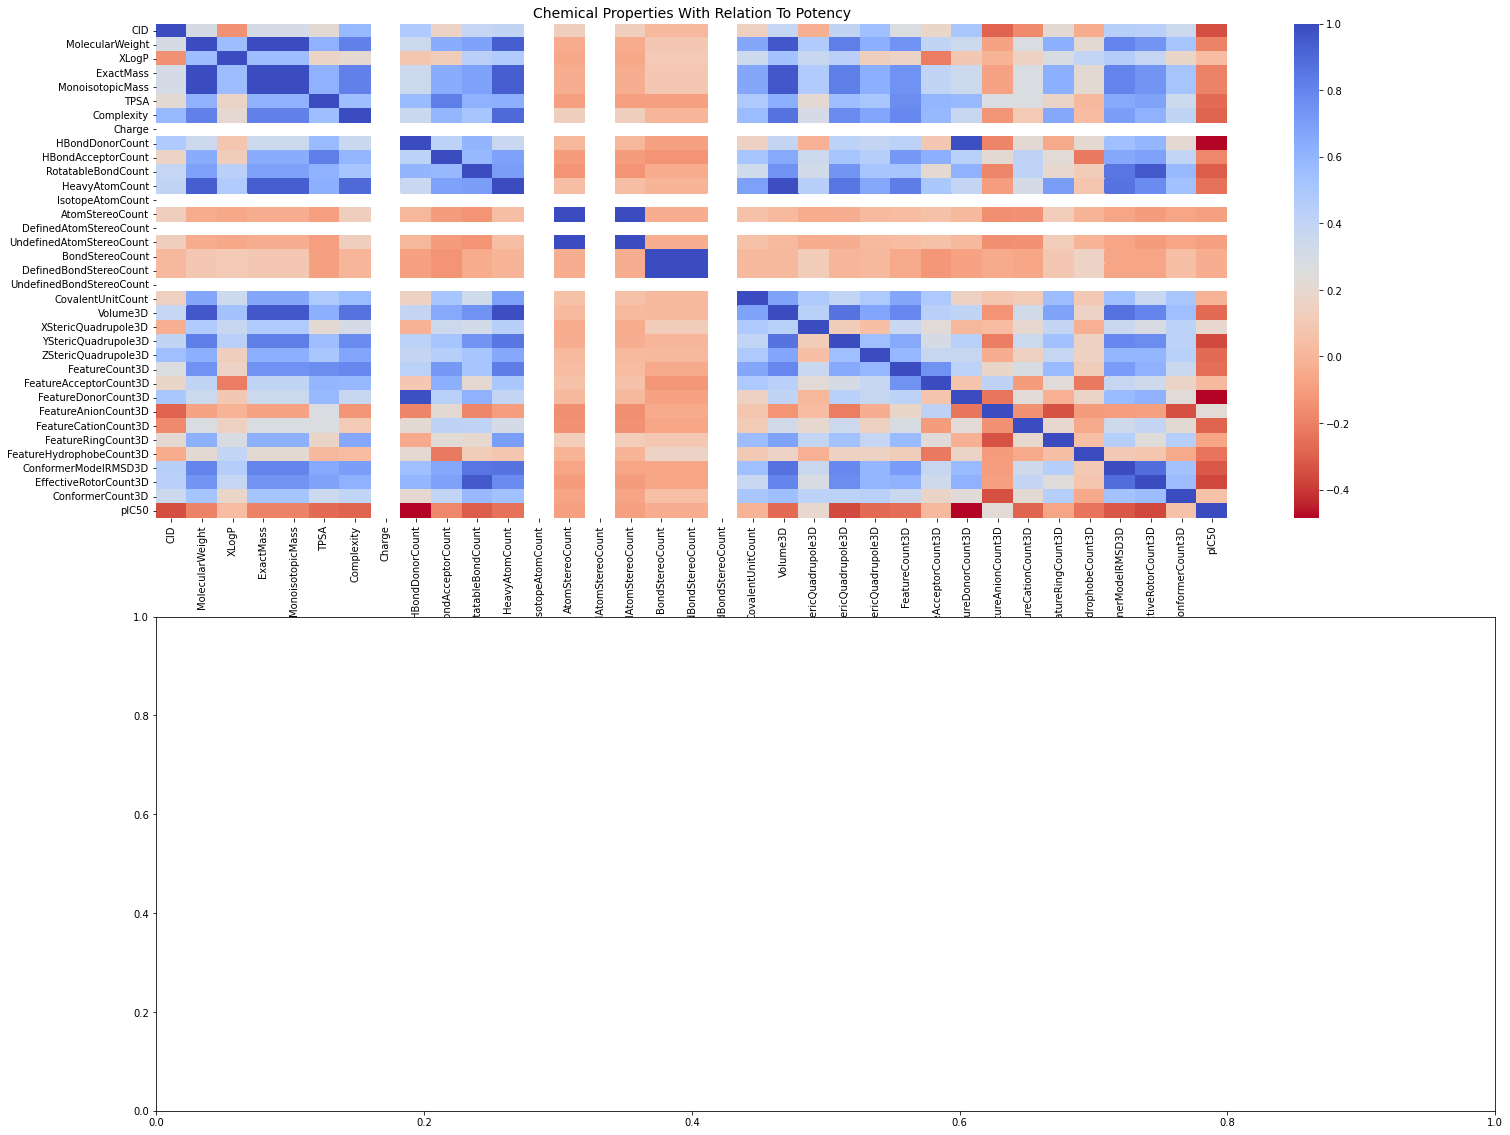

In [ ]:
# Implementing Correlation Matrix

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Chemical Properties With Relation To Potency", fontsize=14)

### Key Features For Further Analysis
Negative correlation with pIC50 class

- HBond Donor Count
- Feature Donor Count 3D
- Effective Rotor Count
- Ysteric Quadruple Count


In [ ]:
# Using this to copy paste into the boxplot analysis
df.columns

Index(['CID', 'SMILES', 'MolecularFormula', 'MolecularWeight', 'InChI',
       'InChIKey', 'IUPACName', 'XLogP', 'ExactMass', 'MonoisotopicMass',
       'TPSA', 'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount',
       'RotatableBondCount', 'HeavyAtomCount', 'IsotopeAtomCount',
       'AtomStereoCount', 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount',
       'BondStereoCount', 'DefinedBondStereoCount', 'UndefinedBondStereoCount',
       'CovalentUnitCount', 'Volume3D', 'XStericQuadrupole3D',
       'YStericQuadrupole3D', 'ZStericQuadrupole3D', 'FeatureCount3D',
       'FeatureAcceptorCount3D', 'FeatureDonorCount3D', 'FeatureAnionCount3D',
       'FeatureCationCount3D', 'FeatureRingCount3D',
       'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D',
       'EffectiveRotorCount3D', 'ConformerCount3D', 'pIC50'],
      dtype='object')

Text(0.5, 1.0, 'YStericQuadrupole3D vs Class Negative Correlation')

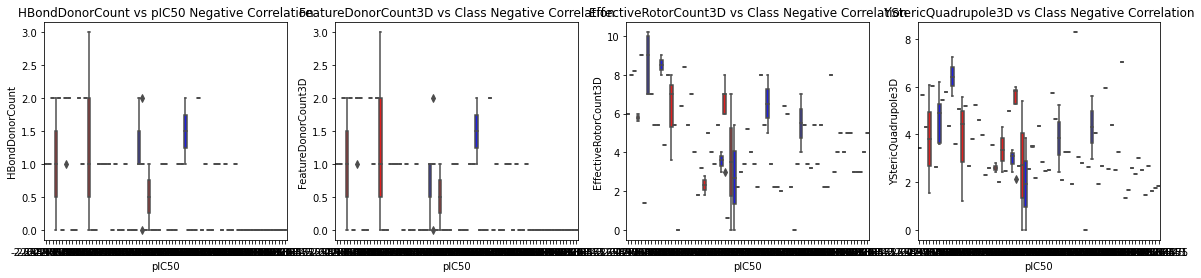

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ['blue', 'red']

# Negative Correlations with pIC50 (The lower our feature value the more likely it will be increase drug potency)
sns.boxplot(x="pIC50", y="HBondDonorCount", data=df, palette=colors, ax=axes[0])
axes[0].set_title('HBondDonorCount vs pIC50 Negative Correlation')

sns.boxplot(x="pIC50", y="FeatureDonorCount3D", data=df, palette=colors, ax=axes[1])
axes[1].set_title('FeatureDonorCount3D vs Class Negative Correlation')


sns.boxplot(x="pIC50", y="EffectiveRotorCount3D", data=df, palette=colors, ax=axes[2])
axes[2].set_title('EffectiveRotorCount3D vs Class Negative Correlation')


sns.boxplot(x="pIC50", y="YStericQuadrupole3D", data=df, palette=colors, ax=axes[3])
axes[3].set_title('YStericQuadrupole3D vs Class Negative Correlation')

## Data Transformations

## Model Training and Testing

# Model Evaluation

## Conclusion & Next Steps